## Решение

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import clear_output
import os
import pickle
from typing import Any, Callable, Optional, Tuple
from PIL import Image
import copy
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.modules.batchnorm import BatchNorm1d

import torchvision
from torchvision import transforms

from torchvision.datasets.vision import VisionDataset
from torch.optim import lr_scheduler

import math
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

dataset_root = "/content/drive/MyDrive/сириус/"


import time
from tqdm import tqdm, tqdm_notebook


# from scipy import ndimage
import cv2

import itertools
from sklearn.metrics import confusion_matrix

Mounted at /content/drive


In [ ]:
classes_number = 10

In [ ]:
# необходимые функции.

def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


def fit_epoch(dataloader, model, loss_fn, optimizer):
    # initialize tracked variables
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # reset the gradient
        optimizer.zero_grad()
        
        # predictions (probabilities), loss, backprop
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # weights update
        optimizer.step()
        
        # predictions (classes)
        preds = torch.argmax(outputs, 1)
        
        # record tracked items
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        
    # record train loss and train accuracy          
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc


def eval_epoch(
    model: torch.nn.Module,
    val_loader: torch.nn.Module,
    criterion: torch.nn.Module
    ) -> (float):
    # set model model into the evaluation mode (e.g. for Dropout)
    model.eval()
    
    # initialize tracked variables
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
        
        # record tracked items
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        
    # record val loss and val accuracy
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc


def train(
    train_loader,
    val_loader,
    model,
    criterion,
    epochs,
    batch_size,
    optimizer,
    scheduler,
    shuffle=True,
    sampler=None,
    patience=5
    ):
    
    # to record the total training time
    since = time.time()
    ###############
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    #################
    
    # init variables to store best model weights, best accuracy, best epoch number, epochs since best accuracy acheived
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10
    best_epoch = 0
    epochs_since_best = 0
    
    # history and log
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(1, epochs+1):
            print(f"epoch {epoch}:\n")
            
            print("Fitting on train data...")
            # all arguments except train loader are from parameters passed to train() arguments
            train_loss, train_acc = fit_epoch( train_loader, model, criterion, optimizer)
            print("train loss:", train_loss)
            
            print("Evaluating on validation data...")
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            print("val loss:", val_loss)
            
            # record history
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            # update learning rate for the optimizer
            scheduler.step()
            
            # display learning status
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            # deep copy the model if it acheives the best validation performance
            if val_loss < best_loss:
                best_loss = val_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
                print()
            else:
                print("worse")
                epochs_since_best += 1
            
            # early stopping
            if epochs_since_best > patience:
                print(f'Stopping training. The validation metric has not improved for {patience} epochs.')
                break
            
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    print('Best epoch: {}'.format(best_epoch))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
            
    return history

def predict(model: torch.nn.Module,
            test_loader: torch.nn.Module
            ) -> np.array:
            
    with torch.no_grad():
        logits = []
        
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs


# Воспользуемся функцией из документации matplotlib, выводящей confusion matrix 
# Source https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(16,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    
def show_confusion_matrix_fucn(model):
    """Построить и посчитать точность классов по confusion matrix"""
    y_test_all = torch.Tensor().long()
    predictions_all = torch.Tensor().long()

    # Пройдём по всему validation датасету и запишем ответы сети
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            predictions = model(inputs.to(device))
            y_test = labels
            _, predictions = torch.max(predictions.cpu(), 1)

            # Аналог append для list
            y_test_all = torch.cat((y_test_all, y_test), 0)
            predictions_all = torch.cat((predictions_all, predictions), 0)

    feature_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    y_test_all = y_test_all.numpy()
    predictions_all = predictions_all.numpy()

    # Функция из sklearn, создаёт confusion матрицу
    cm = confusion_matrix(y_test_all, predictions_all)
    # Выведем её
    plot_confusion_matrix(cm, feature_names, normalize=True)
    
    return y_test_all, predictions_all
  
def accurancy_for_each_class(y_test_all, predictions_all):
    class_correct = [0 for i in range(classes_number)]
    class_total = [0 for i in range(classes_number)]
    feature_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

    c = (predictions_all == y_test_all).squeeze()
    for i in range(len(predictions_all)):
        label = predictions_all[i]            
        class_correct[label] += c[i].item()
        class_total[label] += 1

    print(class_total)
    print(len(class_total))

    for i in range(classes_number):
        print('Accuracy of %5s : %2d %%' % (
            (feature_names[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))
        
def find_lr(model, dataloaders, loss_fn, optimizer, init_value=1e-8,
            final_value=10.0, use_gpu=True):
    """Слегка модифицированная функция для поиска оптимального learning rate 
    функция взята из  книги книги "Ian Pointer - Programming PyTorch
    for Deep Learning - Creating and Deploying Deep Learning Applications-
    O’Reilly Media (2019)
    """
    
    model.train()
    number_in_epoch = len(dataloaders) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for inputs, labels in dataloaders:
        if use_gpu:
            inputs = inputs.to(device)
            labels = labels.to(device)

        batch_num += 1
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            return log_lrs[10:-5], losses[10:-5]

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values

        losses.append(loss)
        log_lrs.append(math.log10(lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    return log_lrs[10:-5], losses[10:-5]

def predict_2(model, test_loader):
    with torch.no_grad():
        logits = []
        
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1)
    return torch.argmax(probs, 1)

def write_solution(filename, labels):
    with open(filename, 'w') as solution:
        print('Id,Category', file=solution)
        for i, label in enumerate(labels):
            print(f'{i},{label}', file=solution)

In [ ]:
!nvidia-smi
torch.cuda.is_available()

Fri Feb 11 11:57:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
DATA_MODES = ['train', 'val', 'test']
device = "cuda" if torch.cuda.is_available() else "cpu"

# New Section

In [ ]:
meta_path = os.path.join('/content/drive/MyDrive/сириус/', 'meta')
with open(meta_path, "rb") as f:
    content = pickle.load(f)
    classes = content['label_names']
    class_to_idx = {_class: i for i, _class in enumerate(classes)}

data_path = os.path.join('/content/drive/MyDrive/сириус/', 'data_train')
with open(data_path, "rb") as f:
    content = pickle.load(f)
    data = content['images']
    targets = content.get('labels')

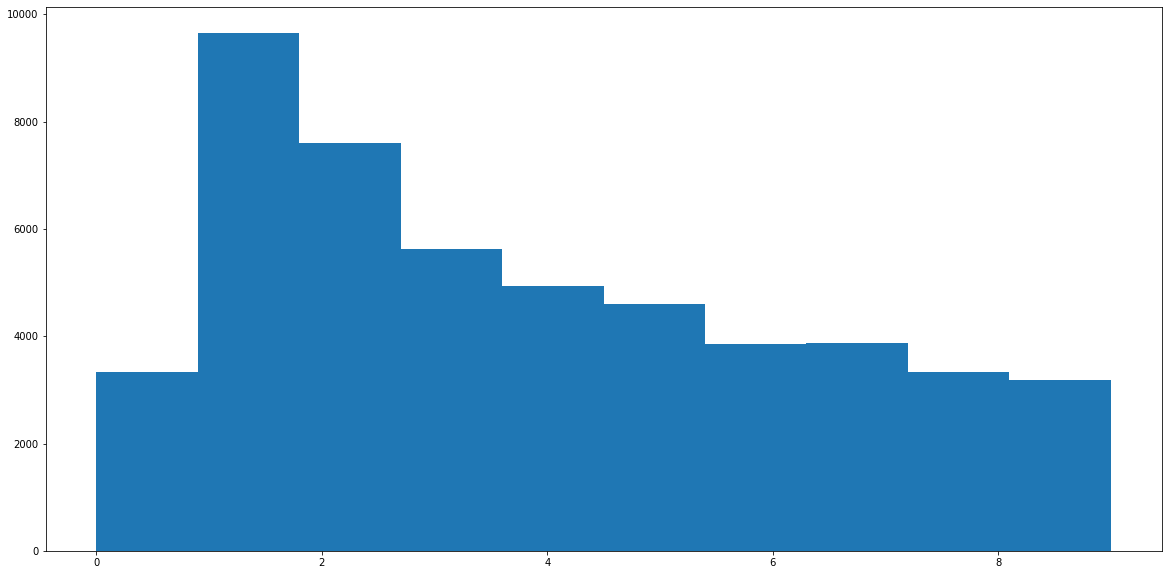

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(targets, bins=10)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data,targets, test_size=0.20, stratify=targets)

In [ ]:
from PIL import ImageFilter
class SVHN(Dataset):

    def __init__(self, 
                 data: list = [], 
                 target: list = [], 
                 mode: str = '',
                 ) -> None:

        super().__init__()
        self.data = data 
        self.target = target
        self.mode = mode           # working mode
        self.len_ = len(self.data)  
    
    def __len__(self) -> int:
        return self.len_

    def __targets__(self) -> int:
        return self.targets
      
    def load_sample(self, index):
        inputimage = Image.fromarray(self.data[index].astype(np.uint8))
        inputimage = np.array(inputimage)

        ####################333
        filteredImage  = cv2.medianBlur(inputimage, ksize=3)


        # grayscaleImage = cv2.cvtColor(inputimage, cv2.COLOR_BGR2GRAY)
        # # Get low mask:
        # _, lowMask = cv2.threshold(grayscaleImage, 10, 255, cv2.THRESH_BINARY_INV)
        # # Get high mask:
        # _, highMask = cv2.threshold(grayscaleImage, 250, 255, cv2.THRESH_BINARY)
        # # Create outliers mask:
        # outliersMask = cv2.add(lowMask, highMask)
        # # Set kernel (structuring element) size:
        # kernelSize = 3
        # # Set operation iterations:
        # opIterations = 1
        # # Get the structuring element:
        # maxKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernelSize, kernelSize))
        # # Apply dilation:
        # outliersMask = cv2.dilate(outliersMask, maxKernel)
        # # Re-shape the binaruy mask to a 3-channeled image:
        # augmentedBinary = cv2.merge([outliersMask, outliersMask, outliersMask])
        # # Apply the adaptive filter:
        # img = np.where(augmentedBinary == (255, 255, 255), filteredImage, inputimage)
        # image = Image.fromarray(filteredImage)
        ################  


        image = Image.fromarray(filteredImage)
        
        # image= image.filter(ImageFilter.EDGE_ENHANCE_MORE)
        
        if self.mode != 'test':
            target = self.target[index]
        else:
            target = []
        return image, target
    
    def __getitem__(self, index):
        # converts to PyTorch tensors and normalises the input
        
        data_transforms = {
            'train': transforms.Compose([
                transforms.RandomPerspective(distortion_scale=0.3, p=0.4),
                transforms.ColorJitter(hue=(-0.5,0.5)),
                transforms.RandomRotation(degrees=40),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], 
                                     [0.229, 0.224, 0.225])
                ]),

            'val_test': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], 
                                     [0.229, 0.224, 0.225])]) 
            ,
        }

        transform = (data_transforms['train'] if self.mode == 'train' else data_transforms['val_test'])
        
        x , _ = self.load_sample(index)  # load image
        x = transform(x)                         # apply transform defined above
        
        if self.mode == 'test':
            return x
        else:
            label = self.target[index]
            return x, label

In [ ]:
train_data = SVHN(X_train, y_train, mode='train')

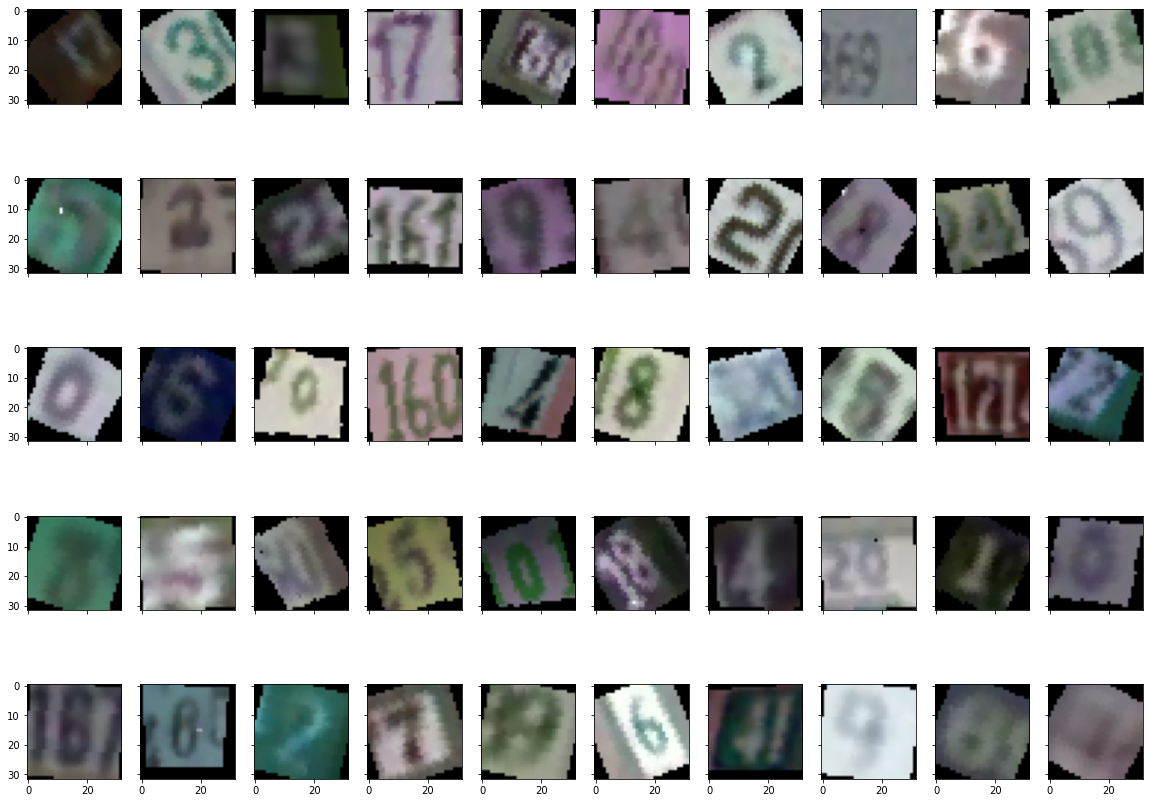

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=10,figsize=(20, 15), \
                        sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,10000))
    im_val,_= train_data[random_characters]

    imshow(im_val.data.cpu(),plt_ax=fig_x)

# Обучение

In [ ]:
val_dataset = SVHN(X_test, y_test, mode='val')
train_dataset = SVHN(X_train, y_train, mode='train')

In [ ]:
class SimpleCnn_1(nn.Module):

    def __init__(self, n_classes):
        super().__init__()

        self.lay_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, 
                      padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32)
            )
        
        self.lay_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1,
                      padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout2d(p=0.3)
            )
        
        self.lay_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3, stride=1,),
            nn.ReLU(),
            nn.BatchNorm2d(128)
            )
#
        self.lay_4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256,kernel_size=2, stride=1,
                      padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.5)
            )

        self.lay_5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512,kernel_size=3, stride=1,
                      padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(512)
            )

        self.lay_6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256,kernel_size=2, stride=1,
                      padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.25)
            )

        self.lay_7 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512,kernel_size=2, stride=1,
                      padding='same'),
            nn.LeakyReLU(),
            nn.BatchNorm2d(512)
            )

        self.lay_8 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024,kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.3)
            )

        self.final = nn.Sequential(nn.Flatten(),
                                  #  768
                                   nn.Linear(2304, 4096),
                                   nn.ReLU(),
                                   nn.Linear(4096, 1024),
                                   nn.BatchNorm1d(1024),
                                   nn.ReLU(),
                                   nn.Dropout(p=0.4),
                                   nn.Linear(1024, 512),
                                   nn.ReLU()
            )
        self.out =  nn.Linear(512, n_classes) 

    def forward(self, x):
        x = self.lay_1(x)
        # print(x.shape, 'x_1')
      
        x = self.lay_2(x)
        # print(x.shape, 'l2')
        x = self.lay_3(x)
        # print(x.shape, 'l3')
        x = self.lay_4(x)
        # print(x.shape, 'l4')
        x = self.lay_5(x)
        # print(x.shape, 'l5')
        x = self.lay_6(x)
        # print(x.shape, 'l6')


        x = self.lay_7(x)
        # print(x.shape, 'l7')
        x = self.lay_8(x)
        # print(x.shape, 'l8')



        x = self.final(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
model= SimpleCnn_1(10).to(device)

BATCH_SIZE = 64 

# loss
criterion = nn.CrossEntropyLoss()

# learning rate optimizer
optimizer = torch.optim.AdamW(model.parameters(),amsgrad=True)

# scheduler for the lr optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)  

history_feature_extr = train(train_dataset, val_dataset, model=model, criterion=criterion,
                             epochs=40, batch_size=BATCH_SIZE, optimizer=optimizer, scheduler=scheduler)

epoch:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 1:

Fitting on train data...
train loss: 2.2329052837371828
Evaluating on validation data...


epoch:   2%|▎         | 1/40 [00:44<28:40, 44.12s/it]

val loss: 2.0763572853088377

Epoch 001 train_loss: 2.2329     val_loss 2.0764 train_acc 0.1928 val_acc 0.2763

epoch 2:

Fitting on train data...
train loss: 1.3212100645542144
Evaluating on validation data...


epoch:   5%|▌         | 2/40 [01:28<28:08, 44.42s/it]

val loss: 0.6463768923759461

Epoch 002 train_loss: 1.3212     val_loss 0.6464 train_acc 0.5452 val_acc 0.7925

epoch 3:

Fitting on train data...
train loss: 0.5830158532619476
Evaluating on validation data...


epoch:   8%|▊         | 3/40 [02:14<27:37, 44.79s/it]

val loss: 0.4043667534828186

Epoch 003 train_loss: 0.5830     val_loss 0.4044 train_acc 0.8182 val_acc 0.8785

epoch 4:

Fitting on train data...
train loss: 0.4555664800643921
Evaluating on validation data...


epoch:  10%|█         | 4/40 [03:02<27:43, 46.20s/it]

val loss: 0.3534973869800568

Epoch 004 train_loss: 0.4556     val_loss 0.3535 train_acc 0.8612 val_acc 0.8928

epoch 5:

Fitting on train data...
train loss: 0.39681457558870314
Evaluating on validation data...


epoch:  12%|█▎        | 5/40 [03:53<27:58, 47.95s/it]

val loss: 0.36025890913009645

Epoch 005 train_loss: 0.3968     val_loss 0.3603 train_acc 0.8779 val_acc 0.8875
worse
epoch 6:

Fitting on train data...
train loss: 0.357904891204834
Evaluating on validation data...


epoch:  15%|█▌        | 6/40 [04:46<28:07, 49.62s/it]

val loss: 0.3044353572845459

Epoch 006 train_loss: 0.3579     val_loss 0.3044 train_acc 0.8918 val_acc 0.9093

epoch 7:

Fitting on train data...
train loss: 0.28776145067214964
Evaluating on validation data...


epoch:  18%|█▊        | 7/40 [05:29<26:05, 47.45s/it]

val loss: 0.2603506695270538

Epoch 007 train_loss: 0.2878     val_loss 0.2604 train_acc 0.9134 val_acc 0.9226

epoch 8:

Fitting on train data...
train loss: 0.26272759420871733
Evaluating on validation data...


epoch:  20%|██        | 8/40 [06:12<24:32, 46.01s/it]

val loss: 0.24144608430862427

Epoch 008 train_loss: 0.2627     val_loss 0.2414 train_acc 0.9215 val_acc 0.9296

epoch 9:

Fitting on train data...
train loss: 0.24721170746684074
Evaluating on validation data...


epoch:  22%|██▎       | 9/40 [06:59<24:01, 46.50s/it]

val loss: 0.24346839706897735

Epoch 009 train_loss: 0.2472     val_loss 0.2435 train_acc 0.9270 val_acc 0.9283
worse
epoch 10:

Fitting on train data...
train loss: 0.2353772003531456
Evaluating on validation data...


epoch:  25%|██▌       | 10/40 [07:42<22:43, 45.46s/it]

val loss: 0.23402130616903305

Epoch 010 train_loss: 0.2354     val_loss 0.2340 train_acc 0.9298 val_acc 0.9337

epoch 11:

Fitting on train data...
train loss: 0.223281685847044
Evaluating on validation data...


epoch:  28%|██▊       | 11/40 [08:25<21:37, 44.74s/it]

val loss: 0.23192482550144194

Epoch 011 train_loss: 0.2233     val_loss 0.2319 train_acc 0.9316 val_acc 0.9337

epoch 12:

Fitting on train data...
train loss: 0.21106490491628646
Evaluating on validation data...


epoch:  30%|███       | 12/40 [09:09<20:42, 44.38s/it]

val loss: 0.24418139379024506

Epoch 012 train_loss: 0.2111     val_loss 0.2442 train_acc 0.9358 val_acc 0.9334
worse
epoch 13:

Fitting on train data...
train loss: 0.18331092946827413
Evaluating on validation data...


epoch:  32%|███▎      | 13/40 [09:52<19:48, 44.03s/it]

val loss: 0.22230436676740647

Epoch 013 train_loss: 0.1833     val_loss 0.2223 train_acc 0.9459 val_acc 0.9385

epoch 14:

Fitting on train data...
train loss: 0.17242870741188526
Evaluating on validation data...


epoch:  35%|███▌      | 14/40 [10:36<19:01, 43.92s/it]

val loss: 0.21543022807240486

Epoch 014 train_loss: 0.1724     val_loss 0.2154 train_acc 0.9490 val_acc 0.9385

epoch 15:

Fitting on train data...
train loss: 0.16553669694066048
Evaluating on validation data...


epoch:  38%|███▊      | 15/40 [11:19<18:12, 43.71s/it]

val loss: 0.22859033148288727

Epoch 015 train_loss: 0.1655     val_loss 0.2286 train_acc 0.9508 val_acc 0.9366
worse
epoch 16:

Fitting on train data...
train loss: 0.15472806664407254
Evaluating on validation data...


epoch:  40%|████      | 16/40 [12:02<17:24, 43.53s/it]

val loss: 0.22216108615994454

Epoch 016 train_loss: 0.1547     val_loss 0.2222 train_acc 0.9543 val_acc 0.9382
worse
epoch 17:

Fitting on train data...
train loss: 0.15188010204285382
Evaluating on validation data...


epoch:  42%|████▎     | 17/40 [12:45<17:16, 45.06s/it]

val loss: 0.21723024772405625

Epoch 017 train_loss: 0.1519     val_loss 0.2172 train_acc 0.9551 val_acc 0.9415
worse
Stopping training. The validation metric has not improved for 5 epochs.
Training complete in 12m 46s
Best val loss: 0.215430
Best epoch: 14


In [ ]:
model= SimpleCnn_1(10).to(device)

BATCH_SIZE = 64 

# loss
criterion = nn.CrossEntropyLoss()

# learning rate optimizer
optimizer = torch.optim.AdamW(model.parameters(),amsgrad=True)

# scheduler for the lr optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)  

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, sampler=None, num_workers=2)
logs, losses = find_lr(model, train_loader, criterion, optimizer, init_value=1e-8, final_value=10.0)

Text(0, 0.5, 'loss')

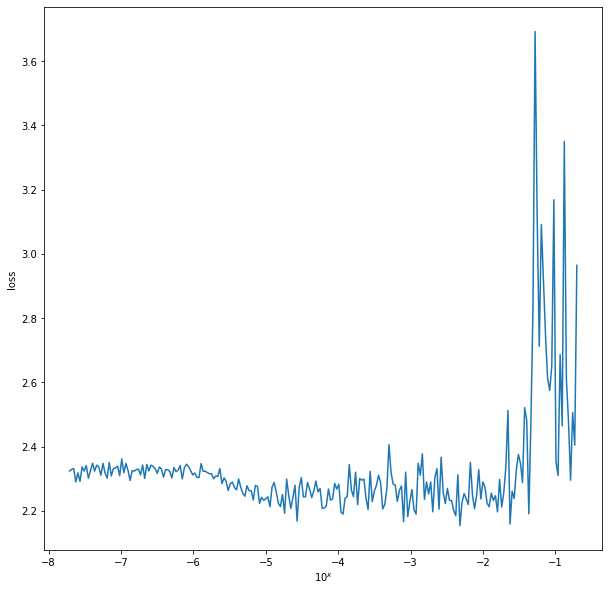

In [ ]:
# построим график для оптимального подбора lr
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(logs,losses)
ax.set_xlabel("$10^x$")
ax.set_ylabel("loss")

In [ ]:
model= SimpleCnn_1(10).to(device)

BATCH_SIZE = 64 

# loss
criterion = nn.CrossEntropyLoss()

# learning rate optimizer
optimizer = torch.optim.AdamW(model.parameters(),amsgrad=True)

# scheduler for the lr optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)  

In [ ]:
BATCH_SIZE = 512
# DataLoader достаёт данные из dataset батчами
dataloaders = {'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(train_dataset), 'val':len(val_dataset) }

Normalized confusion matrix


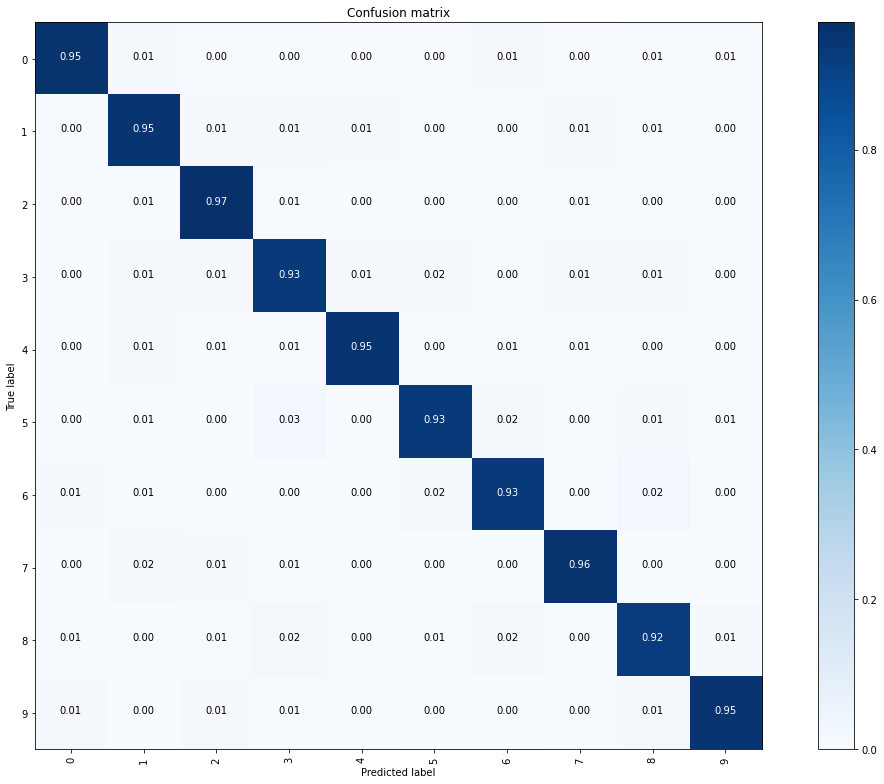

In [ ]:
# Построим confusion_matrix
y_test_all, predictions_all = show_confusion_matrix_fucn(model)

In [ ]:
accurancy_for_each_class(y_test_all, predictions_all)

[664, 1965, 1511, 1125, 991, 937, 774, 761, 644, 628]
10
Accuracy of     0 : 95 %
Accuracy of     1 : 94 %
Accuracy of     2 : 96 %
Accuracy of     3 : 92 %
Accuracy of     4 : 95 %
Accuracy of     5 : 93 %
Accuracy of     6 : 93 %
Accuracy of     7 : 95 %
Accuracy of     8 : 92 %
Accuracy of     9 : 95 %


# Предсказание и запись результатов.

Загружаем часть датасета для теста.

In [ ]:
# с моим даталоадером

data_path = os.path.join('/content/drive/MyDrive/сириус/', 'data_test')
with open(data_path, "rb") as f:
    content = pickle.load(f)
    data = content['images']

test_dataset = SVHN(data, mode='test')
test_dataset = DataLoader(test_dataset, batch_size=256, shuffle=False, sampler=None, num_workers=2)

pred = predict_2(model, test_dataset)
            
write_solution('solution.csv', pred)